In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import DataFrame, Series
from matplotlib import pylab as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Imputer
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# Быстрое перемещение
1. [Предобработка данных](#Предобработка-данных)
1. [Эксплоративый анализ](#Эксплоративый-анализ)
1. [Случайный лес](#Случайный-лес) - [Результаты](#Результаты:-случайный-лес)
1. [Бэггинг](#Бэггинг)
1. [Сводные результаты](#Сводные-результаты)

## TODO
1. Предобработка данных:
  - X1 перевести в инты;
  - разобраться с NaN в X3 и X7;
1. Эксплоративный анализ:
  - посмотреть корреляцию -> выкидывать ли сильно коррелируемые признаки(?);
  - построить диаграмму матрицы распределения -> есть ли линейная разделимость -> ядро SVM, логит регрессия;
1. Случайный лес:
    - убрать ли пропущенные значения или сделать импутирование средним;
    - настроить параметры серч гридом;
1. Бэггинг:
    - выбрать алгоритм;
    - настроить параметры рэндом гридом;
1. Сводные результаты:
    - сделать сводную таблицу по случайному лесу и бэггингу акьюраси и рок-аук

# Предобработка данных  
[Вернуться в начало](#Быстрое-перемещение)

In [2]:
dataset = DataFrame.from_csv('Zadanie.csv/Zadanie.csv', index_col=None)
dataset.head()

,Y,X1,X2,X3,X4,X5,X6,X7
0,1,A,0,0.361169,0,0,0,0.412503
1,1,A,1,0.009395,1,2,3,0.295806
2,0,A,0,0.022964,1,2,3,0.295806
3,0,A,1,0.373695,1,2,3,0.295806
4,0,A,0,0.311064,1,2,3,0.295806


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
Y     1309 non-null int64
X1    1309 non-null object
X2    1309 non-null int64
X3    1046 non-null float64
X4    1309 non-null int64
X5    1309 non-null int64
X6    1309 non-null int64
X7    1308 non-null float64
dtypes: float64(2), int64(5), object(1)
memory usage: 76.7+ KB


In [4]:
dataset['X1'].unique()

array(['A', 'B', 'C'], dtype=object)

In [5]:
dataset = dataset.replace(['A', 'B', 'C'], [1, 2, 3])

In [6]:
dataset.isnull().sum() / dataset.count()

Y     0.000000
X1    0.000000
X2    0.000000
X3    0.251434
X4    0.000000
X5    0.000000
X6    0.000000
X7    0.000765
dtype: float64

Доля пропущенных значений X7 слишком мала, спокойно убираем пропущенные значения.  
Доля пропущенных значений X3 велика, с уверенностью убрать пропущенные мы не можем.

In [7]:
dataset = dataset.dropna(subset=['X7'])

Среднее: 0.372
Медиана: 0.349


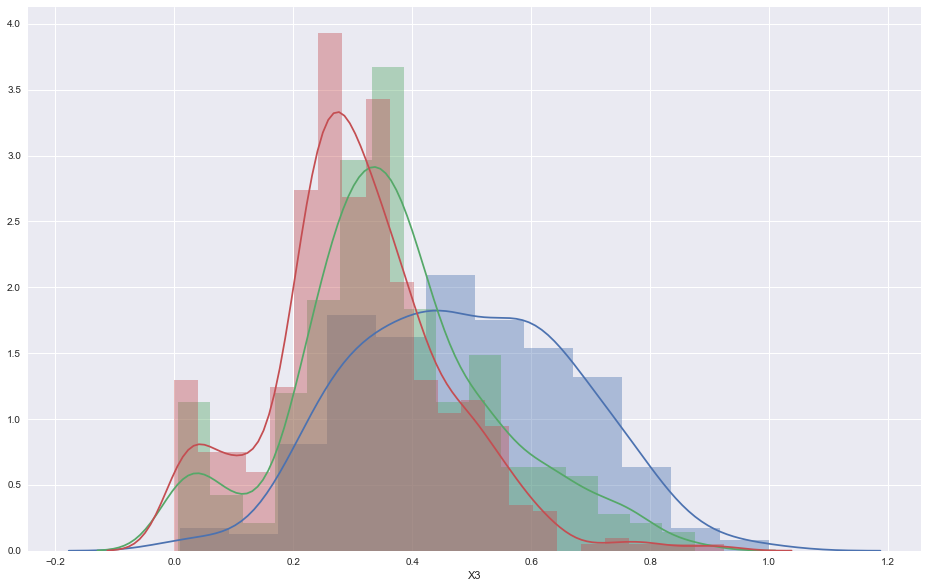

In [8]:
plt.subplots(figsize=(16, 10))
z1 = dataset[dataset['X1'] == 1]
z2 = dataset[dataset['X1'] == 2]
z3 = dataset[dataset['X1'] == 3]
sns.distplot(z1['X3'].dropna())
sns.distplot(z2['X3'].dropna())
sns.distplot(z3['X3'].dropna())
print('Среднее: {:.3}\nМедиана: {:.3}'.format(dataset['X3'].dropna().mean(), dataset['X3'].dropna().median()))

Исходя из этого, можно попробовать заполнить пропущенные значения X3 средним.  
Также сделаем другой датасет, где убирем пропущенные значения.

In [9]:
df = dataset.fillna(round(dataset['X3'].dropna().mean(), 5))

# аналогичные действия для кодирования значений из X2
# lb_encoder = preprocessing.LabelEncoder()
# dataset = dataset.values
# dataset[:, 1] = lb_encoder.fit_transform(dataset[:, 1])

# imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
# imr = imr.fit(dataset)
# df = imr.transform(dataset)
# df = DataFrame(df, columns=dataset.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308 entries, 0 to 1308
Data columns (total 8 columns):
Y     1308 non-null int64
X1    1308 non-null int64
X2    1308 non-null int64
X3    1308 non-null float64
X4    1308 non-null int64
X5    1308 non-null int64
X6    1308 non-null int64
X7    1308 non-null float64
dtypes: float64(2), int64(6)
memory usage: 92.0 KB


In [10]:
df_dna = dataset.dropna()
df_dna = DataFrame(np.array(df_dna), columns=df.columns)
df_dna.head()

,Y,X1,X2,X3,X4,X5,X6,X7
0,1.0,1.0,0.0,0.361169,0.0,0.0,0.0,0.412503
1,1.0,1.0,1.0,0.009395,1.0,2.0,3.0,0.295806
2,0.0,1.0,0.0,0.022964,1.0,2.0,3.0,0.295806
3,0.0,1.0,1.0,0.373695,1.0,2.0,3.0,0.295806
4,0.0,1.0,0.0,0.311064,1.0,2.0,3.0,0.295806


In [11]:
df.shape, df_dna.shape

((1308, 8), (1045, 8))

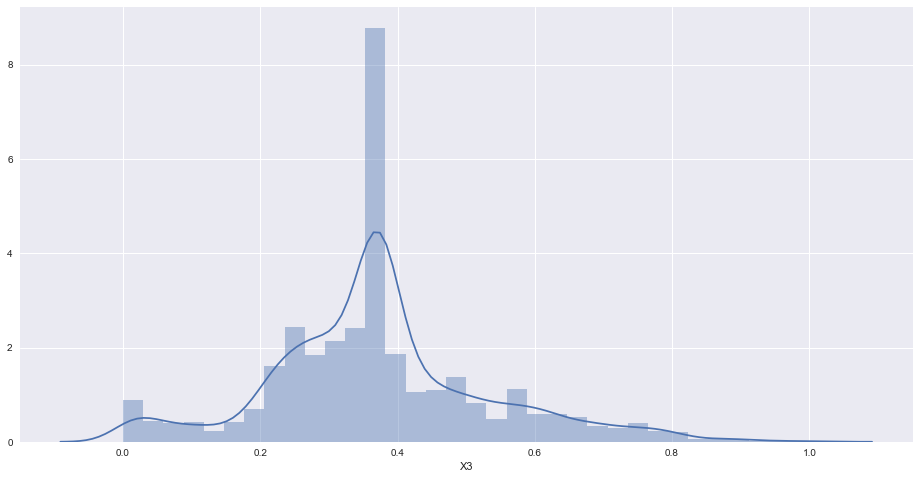

In [12]:
plt.subplots(figsize=(16, 8))
sns.distplot(df['X3'])

# Эксплоративый анализ  
[Вернуться в начало](#Быстрое-перемещение)

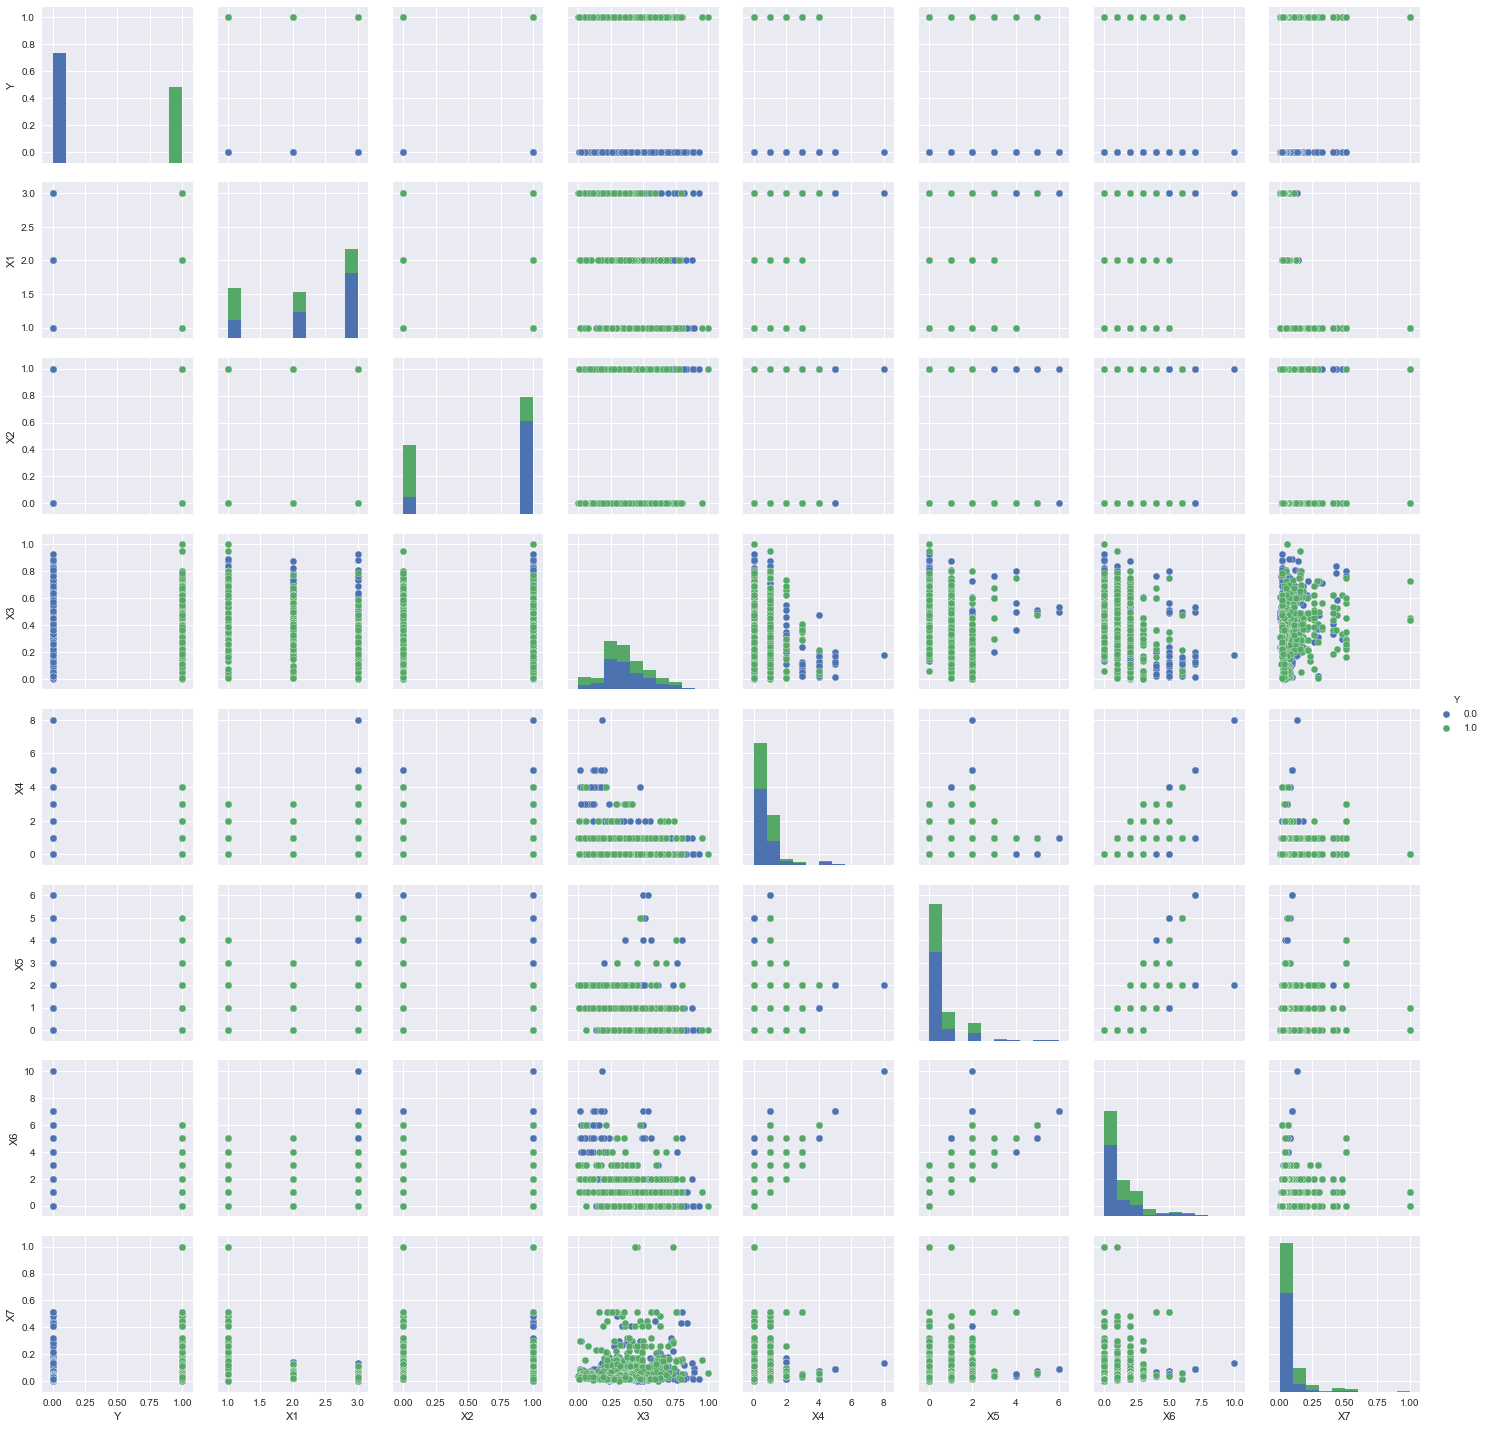

In [13]:
sns.pairplot(df_dna, hue='Y')

Линейной разделимости не наблюдается

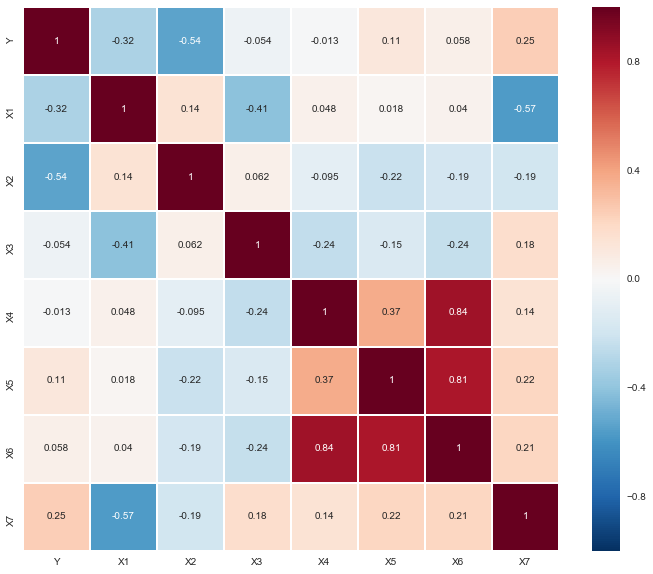

In [14]:
plt.subplots(figsize=(12, 10))
sns.heatmap(df_dna.corr(), annot=True, linewidths=.5)

> "Корреляция не является причинностью"

|Плохо коррелируют|Хорошо коррелируют|
|---|---|
|X4 - X1|X6 - X4|
|X5 - X1|X6 - X5|
|X6 - X1| |
|etc| | 

Пока это не повод убирать признаки

In [15]:
df_dna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 8 columns):
Y     1045 non-null float64
X1    1045 non-null float64
X2    1045 non-null float64
X3    1045 non-null float64
X4    1045 non-null float64
X5    1045 non-null float64
X6    1045 non-null float64
X7    1045 non-null float64
dtypes: float64(8)
memory usage: 65.4 KB


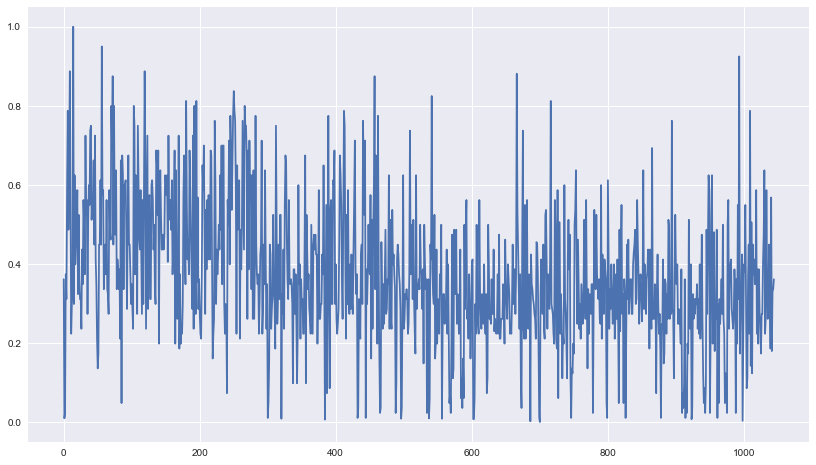

In [16]:
plt.subplots(figsize=(14, 8))
plt.plot(df_dna['X3'])

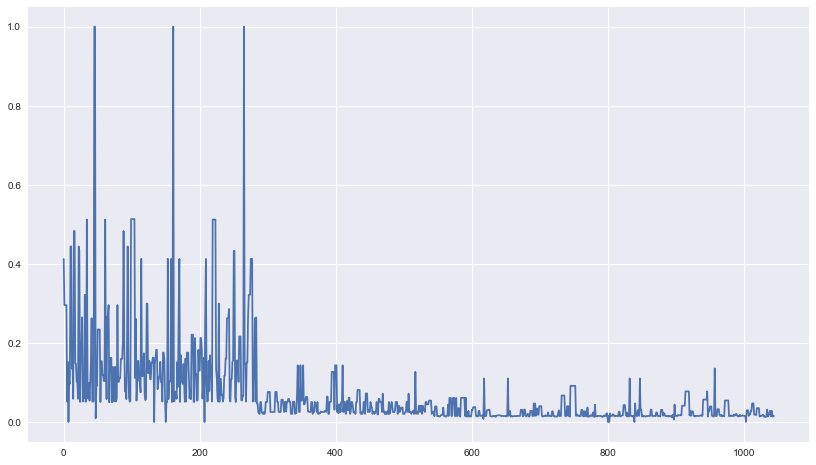

In [17]:
plt.subplots(figsize=(14, 8))
plt.plot(df_dna['X7'])

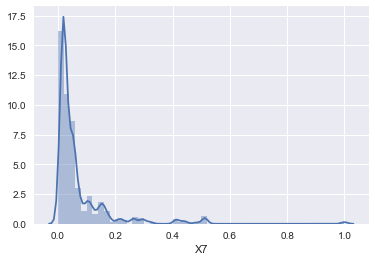

In [18]:
sns.distplot(df_dna['X7'])

In [19]:
df_dna[df_dna['X7'] > 0.6].shape

(4, 8)

4 значения для выброса не так много, чтобы убрать, но будет небольшие улучшения с учетом MinMaxScaler'а

In [20]:
df_dna = df_dna[df_dna['X7'] < 0.6]
df = df[df['X7'] < 0.6]
df_dna.shape, df.shape, dataset.shape

((1041, 8), (1304, 8), (1308, 8))

# Случайный лес  
[Вернуться в начало](#Быстрое-перемещение)

In [21]:
y_df = df['Y']
x_df = df.drop('Y', axis=1)
y_df_dna = df_dna['Y']
x_df_dna = df_dna.drop('Y', axis=1)

In [22]:
X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(x_df, y_df, test_size=0.33, random_state=42)
X_train_dna, X_test_dna, Y_train_dna, Y_test_dna = train_test_split(x_df_dna, y_df_dna, test_size=0.33, random_state=42)

In [23]:
# без настройки гиперпараметров
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)
ress = cross_val_score(rfc, X_train_norm, Y_train_norm, cv=skf)
print("Cross val accuracy score: {:.2f}%".format(ress.mean()))

Cross val accuracy score: 0.76%


## Настройка гиперпараметров  
Для того, чтобы настроить гиперпараметры, мы можем строить кривые валидации для каждого параметра и исходя из них выбирать оптимальное значение, но можем также воспользоваться перебором.

In [24]:
def set_hyperparametrs(x, y):
    """
    функция для настройка гиперпараметров перебором
    """
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    parameters = {'max_features': list(range(1, len(x_df.columns)+1)),
                  'min_samples_leaf': [1, 3, 5, 7],
                  'max_depth': [3, 5, 7, 9]}
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)
    gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
    gcv.fit(x, y)
    
    return rfc, gcv

In [25]:
rfc_imp, gcv_imp = set_hyperparametrs(X_train_norm, Y_train_norm)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  1.7min finished


In [26]:
gcv_imp.best_score_

0.81328751431844215

In [27]:
gcv_imp.best_params_

{'max_depth': 7, 'max_features': 7, 'min_samples_leaf': 3}

In [28]:
gcv_imp.best_estimator_.feature_importances_

array([ 0.15802975,  0.42528759,  0.16577503,  0.01851797,  0.01410473,
        0.04696628,  0.17131867])

In [29]:
rfc_norm = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=7, max_features=7,
                                  min_samples_leaf=3, oob_score=True)
rfc_norm.fit(X_train_norm, Y_train_norm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=7, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [30]:
accuracy_score(Y_test_norm, rfc_norm.predict(X_test_norm))

0.80742459396751742

In [31]:
rfc_dna, gcv_dna = set_hyperparametrs(X_train_dna, Y_train_dna)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  1.7min finished


## Результаты: случайный лес  
[Вернуться в начало](#Быстрое-перемещение)

Так как значение accuracy у двух моделей примерно одинаковое, оставим модель с убранными пропущенными значениями

In [32]:
gcv_dna.best_score_

0.80200860832137733

In [33]:
gcv_dna.best_params_

{'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 3}

In [34]:
gcv_dna.best_estimator_.feature_importances_

array([ 0.18908998,  0.47996535,  0.12201189,  0.0224106 ,  0.0106482 ,
        0.03144736,  0.14442661])

In [35]:
rfc_dna = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=5, max_features=6,
                                 min_samples_leaf=3, oob_score=True)
rfc_dna.fit(X_train_dna, Y_train_dna)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=6, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [49]:
acc_rfc = accuracy_score(Y_test_dna, rfc_dna.predict(X_test_dna))
roc_auc_rfc = roc_auc_score(Y_test_dna, rfc_dna.predict(X_test_dna))
acc_rfc, roc_auc_rfc

(0.81686046511627908, 0.80150578206337575)

### Важность признаков

In [37]:
# убранные пропущенные значения
DataFrame({'feat': [x for x in df_dna if x != 'Y'], 
           'coef': rfc_dna.feature_importances_}).sort_values(by='coef', ascending=False)

,coef,feat
1,0.479965,X2
0,0.189090,X1
6,0.144427,X7
2,0.122012,X3
5,0.031447,X6
3,0.022411,X4
4,0.010648,X5


In [38]:
# с имупитированным средним
DataFrame({'feat': [x for x in df_dna if x != 'Y'], 
           'coef': rfc_norm.feature_importances_}).sort_values(by='coef', ascending=False)

,coef,feat
1,0.425288,X2
6,0.171319,X7
2,0.165775,X3
0,0.158030,X1
5,0.046966,X6
3,0.018518,X4
4,0.014105,X5


Как мы видим, влияние X3 стало больше  
Потеря 25% данных в данном случае является лучшим решением

# Бэггинг  
[Вернуться в начало](#Быстрое-перемещение)   
Для такого датасета мы не можем использовать стекинг алгоритмов, так как данных мало, на тестовую выборку мы должны оставить 1/3 всех данных, к тому же тренировочную выборку нужно разделить на тренировочную и валидационную. Нужно обучать каждый слой стэкинга, поэтому данную процедуру стоит проделать для каждого слоя из-за чего у нас останется слишком мало данных для обучения.

In [39]:
parameters_svc = {'max_features': list(range(1, len(x_df.columns)+1)), 'max_samples': [0.7, 0.9], 
                  'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000],
                  'base_estimator__gamma': [0.01, 0.001, 0.0001], 'base_estimator__kernel': ['linear', 'rbf'],
                  'base_estimator__degree': [2, 3, 4]}

In [40]:
# малый n_iter, потому что слабый компьютер
# можно было использовать лог регрессию, k ближайших соседей, градиентный бустинг и тд
# на бэггинге градиентных бустов, скорее всего, результат был бы лучше, но считалось бы дольше

sc = StandardScaler()
Xtrain_std = sc.fit_transform(X_train_dna)
Xtest_std = sc.fit_transform(X_test_dna)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
bagging_classifier_set = BaggingClassifier(SVC(class_weight='balanced'), 
                                           n_estimators=10, n_jobs=-1, random_state=42)
rand_grid_svc = RandomizedSearchCV(bagging_classifier_set, parameters_svc, n_jobs=-1, scoring ='roc_auc',
                                   cv=skf, n_iter=15, random_state=42, verbose=True)
rand_grid_svc = rand_grid_svc.fit(Xtrain_std, Y_train_dna)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   11.3s finished


In [41]:
rand_grid_svc.best_score_

0.83673939942681375

In [42]:
rand_grid_svc.best_params_

{'base_estimator__C': 100,
 'base_estimator__degree': 4,
 'base_estimator__gamma': 0.001,
 'base_estimator__kernel': 'rbf',
 'max_features': 7,
 'max_samples': 0.7}

In [46]:
bag_svc = BaggingClassifier(SVC(class_weight='balanced', C=100, degree=4, gamma=0.001, kernel='rbf'), n_estimators=10, 
                            n_jobs=-1, random_state=42, max_samples=0.7, max_features=7)
bag_svc.fit(Xtest_std, Y_test_dna)

BaggingClassifier(base_estimator=SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=4, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=7,
         max_samples=0.7, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [50]:
acc_bag_svc = accuracy_score(Y_test_dna, bag_svc.predict(Xtest_std))
roc_auc_bag_svc = roc_auc_score(Y_test_dna, bag_svc.predict(Xtest_std))
acc_bag_svc, roc_auc_bag_svc

(0.79651162790697672, 0.7820983125458546)

# Сводные результаты  
[Вернуться в начало](#Быстрое-перемещение)

In [51]:
results_df = DataFrame({'Accuracy': [acc_rfc, acc_bag_svc],
                        'ROC-AUC': [roc_auc_rfc, roc_auc_bag_svc]}, index=['RFC', 'Bagging SVCs'])
results_df

,Accuracy,ROC-AUC
RFC,0.816860,0.801506
Bagging SVCs,0.796512,0.782098
